In [1]:
import sys 
sys.path.append("../..")
import pandas as pd 
import geopandas as gpd
from tqdm import tqdm
from src.bagData import BagData, create_tensorflow_iterator, create_bag_multiresolution_dictionary
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import gpflow 
from scipy.stats import sem
import json
import random 
import time 
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from src.svgp import MVBAgg
from src.util import optimize_adam, optimize_natgrad_adam, save_model, load_model
from src.plot_util import create_pixel_square,create_point
from sklearn.cluster import KMeans
seed = 0


In [2]:
# read in user-specified counties and states to study
dates = ['04-07', '04-23', '05-09', '05-25',
       '06-10', '06-26', '07-12', '07-28',
       '08-13', '08-29', '09-14', '09-30',
       '10-16']
counties_states = pd.read_csv("../../data/crops/counties-states.csv")
States = ["OHIO","ILLINOIS", "IOWA", "MICHIGAN", "MISSOURI", "NORTH DAKOTA", "SOUTH DAKOTA"]
col_latlon = ["longitude", "latitude"]
col_modis = [f"EVI_{date}" for date in dates]
col_gridmet = [f"pr_{date}" for date in dates] + [f"tmmx_{date}" for date in dates]

# read in and take subset of yield data
df_yield = pd.read_csv("../../data/crops/soybean_yield_2015_2017.csv")
df_yield["key"] = df_yield["County"] + "-" + df_yield["State"]
df_yield = df_yield[df_yield["key"].isin(counties_states["key"])]
df_yield.rename(columns={"Year": "year"}, inplace=True)
df_yield = df_yield.drop_duplicates(["County", "State", "year"])
df_yield["Value"] = np.log(df_yield["Value"])

# read in latlon
df_latlon = pd.read_csv("../../data/crops/processed_covariates/latlon-500_data_500points.csv")
df_latlon["key"] = df_latlon["County"] + "-" + df_latlon["State"]
df_latlon = df_latlon[df_latlon["key"].isin(counties_states["key"])]
df_latlon = df_latlon.drop_duplicates(["County", "State", "longitude", "latitude"])

# read in and take subset of features data
df_modis = pd.read_csv("../../data/crops/processed_covariates/MOD13Q1-1000_data.csv")
df_modis["key"] = df_modis["County"] + "-" + df_modis["State"]
df_modis = df_modis[df_modis["key"].isin(counties_states["key"])]
features = ["year", "key", "County", "State", "longitude", "latitude"] + [f"EVI_{date}" for date in dates]
df_modis = df_modis[features]
df_modis = df_modis.dropna()
df_modis = df_modis.drop_duplicates(["County", "State", "longitude", "latitude", "year"])

# read in and take subset of features data
df_gridmet = pd.read_csv("../../data/crops/processed_covariates/GRIDMET_data.csv")
df_gridmet["key"] = df_gridmet["County"] + "-" + df_gridmet["State"]
df_gridmet = df_gridmet[df_gridmet["key"].isin(counties_states["key"])]
features = ["key", "year", "County", "State", "longitude", "latitude"] + col_gridmet
df_gridmet = df_gridmet[features]
df_gridmet = df_gridmet.drop_duplicates(["County", "State", "longitude", "latitude", "year"])




In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
output_types=(
    tf.int64, 
    tf.int64, 
    tf.int64, 
    tf.int64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64
)
keys = list(set(df_yield[df_yield["year"]==2015].key).intersection(set(df_yield[df_yield["year"]==2017].key)))
keys.sort()

In [8]:
RMSE = []
MAPE  = []
LL  = []
training_time = []
iterations = 20000
lr_adam = 0.001
num_minibatch = 50
latlon_cols = ["longitude", "latitude"]
modis_cols = [f"EVI_{date}" for date in dates]
pr_cols = [f"pr_{date}" for date in dates] 
tmmx_cols = [f"tmmx_{date}" for date in dates] 
all_features = latlon_cols + modis_cols + pr_cols + tmmx_cols
num_resolutions = 4
# write down index of the features
col_index_space = [0, 1]
col_index_modis = [2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12,13,14]
col_index_pr = [15+i for i in range(13)]
col_index_tmmx = [28+i for i in range(13)]

for fold, (train_index, test_index) in tqdm(enumerate(kf.split(keys))):
    county_keys = [keys[key] for key in train_index]
    df_Z = pd.read_csv(f"../../data/crops/processed_covariates/df_Z_MVBAgg_fold{fold}.csv")
    Z = df_Z[df_Z["key"].isin(county_keys)][all_features].values
    
    X_latlon_train = df_latlon[df_latlon["key"].isin(county_keys)].loc[:, latlon_cols].values
    X_latlon_test = df_latlon[df_latlon["key"].isin(county_keys)].loc[:, latlon_cols].values
    X_modis_train = df_modis[df_modis["key"].isin(county_keys) & (df_modis["year"]==2015)].loc[:, modis_cols].values
    X_modis_test = df_modis[df_modis["key"].isin(county_keys) & (df_modis["year"]==2017)].loc[:, modis_cols].values
    X_pr_train = df_gridmet[df_gridmet["key"].isin(county_keys) & (df_gridmet["year"]==2015)].loc[:, pr_cols].values
    X_pr_test = df_gridmet[df_gridmet["key"].isin(county_keys) & (df_gridmet["year"]==2017)].loc[:, pr_cols].values
    X_tmmx_train = df_gridmet[df_gridmet["key"].isin(county_keys) & (df_gridmet["year"]==2015)].loc[:, tmmx_cols].values
    X_tmmx_test = df_gridmet[df_gridmet["key"].isin(county_keys) & (df_gridmet["year"]==2017)].loc[:, tmmx_cols].values
    y_train = df_yield[df_yield["key"].isin(county_keys) & (df_yield["year"]==2015)].Value.values[:, None]
    y_test = df_yield[df_yield["key"].isin(county_keys) & (df_yield["year"]==2017)].Value.values[:, None]

    scaler_y = StandardScaler().fit(y_train)
    y_train = scaler_y.transform(y_train)

    scaler_latlon = StandardScaler().fit(X_latlon_train)
    X_latlon_train = scaler_latlon.transform(X_latlon_train)
    X_latlon_test = scaler_latlon.transform(X_latlon_test)
    
    scaler_modis = StandardScaler().fit(X_modis_train)
    X_modis_train = scaler_modis.transform(X_modis_train)
    X_modis_test = scaler_modis.transform(X_modis_test)

    scaler_pr = StandardScaler().fit(X_pr_train)
    X_pr_train = scaler_pr.transform(X_pr_train)
    X_pr_test = scaler_pr.transform(X_pr_test)
    
    scaler_tmmx = StandardScaler().fit(X_tmmx_train)
    X_tmmx_train = scaler_tmmx.transform(X_tmmx_train)
    X_tmmx_test = scaler_tmmx.transform(X_tmmx_test)
    # fit and train GP regression model
    k_space = gpflow.kernels.Matern32(active_dims=col_index_space)
    k_modis = gpflow.kernels.RBF(active_dims=col_index_modis)
    k_pr = gpflow.kernels.RBF(active_dims=col_index_pr)
    k_tmmx = gpflow.kernels.RBF(active_dims=col_index_tmmx)

    k = k_space + k_modis + k_pr + k_tmmx
    m = MVBAgg(kernel=k, likelihood=gpflow.likelihoods.Gaussian(), inducing_variable=Z, num_resolution=num_resolutions, num_data=len(county_keys))
    gpflow.set_trainable(m.inducing_variable, False)
    break

0it [00:00, ?it/s]2022-01-18 15:42:46.918995: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-18 15:42:46.919033: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-01-18 15:42:46.919039: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-01-18 15:42:46.919200: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-01-18 15:42:46.919219: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-01-18 15:42:46.919222: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-01-18 15:42:46.919609: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU 

In [9]:
load_model(m, f"../../results/usa_crops/MVBAgg_fold{fold}.pickle")
county_shapes = gpd.read_file("../../data/crops/yield_data_final.geojson")
county_shapes["key"] = county_shapes["County"] + "-" + county_shapes["State"]
county_shapes = county_shapes[county_shapes["key"].isin(counties_states["key"])]

## Raw Data Visualisations

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import contextily as ctx

In [14]:
county_shapes.crs = 4326
county_shapes = county_shapes.to_crs(epsg=3857)

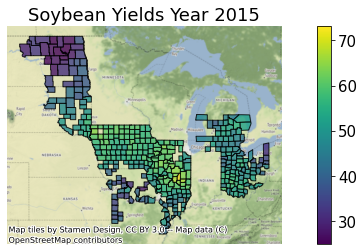

In [33]:
pars = {"size": 15}
plt.rc("font", **pars)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
county_shapes[county_shapes["Year"]==2015].plot(column="Value",ax=ax,cax=cax,
            edgecolor='black', alpha=0.8, legend=True)
ax.set_aspect("equal")
ax.set_title("Soybean Yields Year 2015")
ctx.add_basemap(ax)
ax.axis('off')
plt.savefig("../../results/raw_data/soybeans.pdf")

In [10]:
# read in latlon
df_latlon = pd.read_csv("../../data/crops/processed_covariates/latlon-500_data_all.csv")
df_latlon["key"] = df_latlon["County"] + "-" + df_latlon["State"]
df_latlon = df_latlon[df_latlon["key"].isin(counties_states["key"])]
df_latlon = df_latlon.drop_duplicates(["County", "State", "longitude", "latitude"])

# read in and take subset of features data
df_modis = pd.read_csv("../../data/crops/processed_covariates/MOD13Q1-1000-all_data.csv")
df_modis["key"] = df_modis["County"] + "-" + df_modis["State"]
df_modis = df_modis[df_modis["key"].isin(counties_states["key"])]
features = ["year", "key", "County", "State", "longitude", "latitude"] + [f"EVI_{date}" for date in dates]
df_modis = df_modis[features]
df_modis = df_modis.dropna()
df_modis = df_modis.drop_duplicates(["County", "State", "longitude", "latitude", "year"])

# read in and take subset of features data
df_gridmet = pd.read_csv("../../data/crops/processed_covariates/GRIDMET-all_data.csv")
df_gridmet["key"] = df_gridmet["County"] + "-" + df_gridmet["State"]
df_gridmet = df_gridmet[df_gridmet["key"].isin(counties_states["key"])]
features = ["key", "year", "County", "State", "longitude", "latitude"] + col_gridmet
df_gridmet = df_gridmet[features]
df_gridmet = df_gridmet.drop_duplicates(["County", "State", "longitude", "latitude", "year"])

In [11]:
gridmet_resolution = 0.04166816804999707
df_gridmet["geometry"] = df_gridmet[["longitude", "latitude"]].apply(lambda x: create_pixel_square(x, gridmet_resolution), axis=1)
gdf_gridmet = gpd.GeoDataFrame(df_gridmet)

In [12]:
gdf_gridmet.crs = 4326
gdf_gridmet = gdf_gridmet.to_crs(epsg=3857)

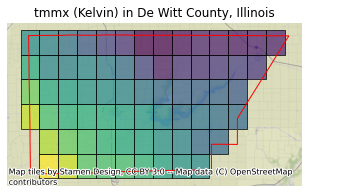

In [18]:
pars = {"size": 10}
plt.rc("font", **pars)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.5)
# gdf_gridmet[(gdf_gridmet["key"]=="DE WITT-ILLINOIS") & (gdf_gridmet["year"]==2015)].plot(column="tmmx_04-07",ax=ax,cax=cax,
#             edgecolor='black', alpha=0.7, legend=True)
gdf_gridmet[(gdf_gridmet["key"]=="DE WITT-ILLINOIS") & (gdf_gridmet["year"]==2015)].plot(column="tmmx_04-07",ax=ax,
            edgecolor='black', alpha=0.7, legend=False)
county_shapes[county_shapes["key"]=="DE WITT-ILLINOIS"].plot(ax=ax,facecolor="None", edgecolor="red", )
ax.set_aspect("equal")
ax.set_title("tmmx (Kelvin) in De Witt County, Illinois")
ctx.add_basemap(ax)
ax.axis('off')
plt.savefig("../../results/raw_data/tmmx_raw.pdf")
plt.savefig("../../results/raw_data/tmmx_raw.png")

In [19]:
modis_resolution = 0.017966999999998734/2
df_modis["geometry"] = df_modis[["longitude", "latitude"]].apply(lambda x: create_pixel_square(x, modis_resolution), axis=1)
gdf_modis = gpd.GeoDataFrame(df_modis)

In [ ]:
gdf_modis.crs = 4326
gdf_modis = gdf_modis.to_crs(epsg=3857)

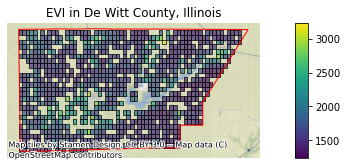

In [132]:
pars = {"size": 10}
plt.rc("font", **pars)
fig, ax = plt.subplots(1, 1, figsize=(5.5, 2.5))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.5)
# gdf_modis[(gdf_modis["key"]=="DE WITT-ILLINOIS") & (gdf_modis["year"]==2015)].plot(column="EVI_04-07",ax=ax,cax=cax,
#             edgecolor='black', alpha=0.7, legend=True)
gdf_modis[(gdf_modis["key"]=="DE WITT-ILLINOIS") & (gdf_modis["year"]==2015)].plot(column="EVI_04-07",ax=ax,
            edgecolor='black', alpha=0.7, legend=False)
county_shapes[county_shapes["key"]=="DE WITT-ILLINOIS"].plot(ax=ax,facecolor="None", edgecolor="red", )
ax.set_aspect("equal")
ax.set_title("EVI in De Witt County, Illinois")
ctx.add_basemap(ax)
ax.axis('off')
plt.savefig("../../results/raw_data/EVI.pdf")
plt.savefig("../../results/raw_data/EVI.png")

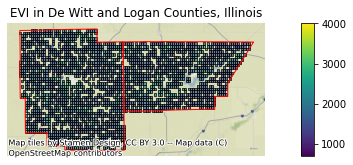

In [134]:
pars = {"size": 10}
plt.rc("font", **pars)
fig, ax = plt.subplots(1, 1, figsize=(5.5, 2.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
gdf_modis[(gdf_modis["key"].isin(["DE WITT-ILLINOIS", "LOGAN-ILLINOIS"])) & (gdf_modis["year"]==2015)].plot(column="EVI_04-07",ax=ax,cax=cax,
            edgecolor='black', alpha=0.7, legend=True)
county_shapes[county_shapes["key"].isin(["DE WITT-ILLINOIS", "LOGAN-ILLINOIS"])].plot(ax=ax,facecolor="None", edgecolor="red", )
ax.set_aspect("equal")
ax.set_title("EVI in De Witt and Logan Counties, Illinois")
ctx.add_basemap(ax)
ax.axis('off')
plt.savefig("../../results/raw_data/EVI_2counties.pdf")

In [123]:
latlon_resolution = 0.017966999999998734/4
df_latlon["geometry"] = df_latlon[["longitude", "latitude"]].apply(lambda x: create_pixel_square(x, latlon_resolution), axis=1)
gdf_latlon = gpd.GeoDataFrame(df_latlon)
gdf_latlon.crs = 4326
gdf_latlon = gdf_latlon.to_crs(epsg=3857)

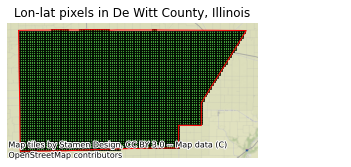

In [130]:
pars = {"size": 10}
plt.rc("font", **pars)
fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.5))
gdf_latlon[gdf_latlon["key"]=="DE WITT-ILLINOIS"].plot(ax=ax,facecolor="green",
            edgecolor='black', alpha=0.7)
county_shapes[county_shapes["key"]=="DE WITT-ILLINOIS"].plot(ax=ax,facecolor="None", edgecolor="red")
ax.set_aspect("equal")
ax.set_title("Lon-lat pixels in De Witt County, Illinois")
ctx.add_basemap(ax)
ax.axis('off')
plt.savefig("../../results/raw_data/latlon.pdf")
plt.savefig("../../results/raw_data/latlon.png")

## MVBAgg Visualisations

In [96]:
modis_resolution = 0.017966999999998734/2

# read in and take subset of features data
df_modis = pd.read_csv("../../data/crops/processed_covariates/MOD13Q1-1000-all_data.csv")
df_modis["key"] = df_modis["County"] + "-" + df_modis["State"]
df_modis = df_modis[df_modis["key"].isin(counties_states["key"])]
df_modis = df_modis[df_modis["year"]==2015]
features = ["year", "key", "County", "State", "longitude", "latitude"] + [f"EVI_{date}" for date in dates]
df_modis = df_modis[features]
df_modis = df_modis.dropna()
df_modis = df_modis.drop_duplicates(["County", "State", "longitude", "latitude", "year"])
df_modis["geometry"] = df_modis[["longitude", "latitude"]].apply(lambda x: create_pixel_square(x, modis_resolution), axis=1)
gdf_modis = gpd.GeoDataFrame(df_modis)
gdf_modis[modis_cols] = scaler_modis.transform(gdf_modis[modis_cols].values)

Join lon-lat, MODIS and GRIDMET

In [97]:
gdf_modis["geometry_2"] = df_modis[["longitude", "latitude"]].apply(lambda x: create_point(x), axis=1)


/home/hbz15/MVBAgg/.env/lib/python3.8/site-packages/pandas-1.3.4-py3.8-linux-x86_64.egg/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [98]:
df_latlon = pd.read_csv("../../data/crops/processed_covariates/latlon-500_data_all.csv")
df_latlon["geometry"] = df_latlon[["longitude", "latitude"]].apply(lambda x: create_point(x), axis=1)
gdf_latlon = gpd.GeoDataFrame(df_latlon)


In [99]:
gdf_joined = gpd.sjoin(gdf_latlon, gdf_modis)

In [100]:
gdf_joined.drop(["geometry"],axis=1, inplace=True)
gdf_joined.rename(columns={"geometry_2": "geometry"}, inplace=True)
gdf_joined = gpd.GeoDataFrame(gdf_joined)

In [101]:
gdf_joined.drop(columns=["latitude_right", "longitude_right"], inplace=True)
gdf_joined.rename(columns={"latitude_left":"latitude", "longitude_left":"longitude"}, inplace=True)

In [102]:
# read in and take subset of features data
df_gridmet = pd.read_csv("../../data/crops/processed_covariates/GRIDMET-all_data.csv")
df_gridmet = df_gridmet[df_gridmet["year"]==2015]
df_gridmet["key"] = df_gridmet["County"] + "-" + df_gridmet["State"]
df_gridmet = df_gridmet[df_gridmet["key"].isin(counties_states["key"])]
features = ["key", "year", "County", "State", "longitude", "latitude"] + pr_cols + tmmx_cols
df_gridmet = df_gridmet[features]
df_gridmet = df_gridmet.drop_duplicates(["County", "State", "longitude", "latitude", "year"])

gridmet_resolution = 0.04166816804999707
df_gridmet_joined = df_gridmet.copy()
df_gridmet_joined = df_gridmet_joined[df_gridmet_joined["year"]==2015]
df_gridmet_joined["geometry"] = df_gridmet[["longitude", "latitude"]].apply(lambda x: create_pixel_square(x, gridmet_resolution), axis=1)
df_gridmet_joined = df_gridmet_joined.drop(["latitude", "longitude"], axis=1)
gdf_gridmet_joined = gpd.GeoDataFrame(df_gridmet_joined)
gdf_joined_all = gpd.sjoin(gdf_gridmet_joined, gdf_joined[col_latlon + modis_cols+["geometry", "key"]])

In [103]:
gdf_joined_all_final = gdf_joined_all.copy()
gdf_joined_all_final["geometry"] = gdf_joined_all_final[["longitude", "latitude"]].apply(lambda x: create_pixel_square(x, modis_resolution/2), axis=1)


In [104]:
gdf_joined_all_final["key"] = gdf_joined_all_final["County"] + "-" + gdf_joined_all_final["State"]
gdf_joined_all_final[latlon_cols] = scaler_latlon.transform(gdf_joined_all_final[latlon_cols].values)
gdf_joined_all_final[modis_cols] = scaler_modis.transform(gdf_joined_all_final[modis_cols].values)
gdf_joined_all_final[pr_cols] = scaler_pr.transform(gdf_joined_all_final[pr_cols].values)


In [105]:
gdf_joined_all_final[tmmx_cols] = scaler_tmmx.transform(gdf_joined_all_final[tmmx_cols].values)

In [106]:
from src.plot_util import plot_full_disaggregation, plot_i_disaggregation

In [15]:
plot_keys = [
    "DE WITT-ILLINOIS",
    "LOGAN-ILLINOIS",
    "PIATT-ILLINOIS",
    "MCLEAN-ILLINOIS",
]

plot_full_disaggregation(
    m, 
    gdf_joined_all_final[gdf_joined_all_final["key"].isin(plot_keys)], 
    all_features, 
    scaler_y=scaler_y, 
    bag_shapefile=county_shapes[county_shapes["key"].isin(plot_keys)], 
)
plt.savefig("../../results/usa_crops/full_disagg.pdf")

In [65]:
gdf_gridmet[tmmx_cols] = scaler_tmmx.transform(gdf_gridmet[tmmx_cols].values)


In [114]:
gdf_gridmet

,key,year,County,State,longitude,latitude,pr_04-07,pr_04-23,pr_05-09,pr_05-25,...,tmmx_06-10,tmmx_06-26,tmmx_07-12,tmmx_07-28,tmmx_08-13,tmmx_08-29,tmmx_09-14,tmmx_09-30,tmmx_10-16,geometry
8014,DE WITT-ILLINOIS,2015,DE WITT,ILLINOIS,-89.103934,40.062395,2.509569,0.0,11.416080,0.0,...,306.540863,295.630615,304.208710,306.178986,302.328583,300.609314,301.481750,294.490112,288.629211,"POLYGON ((-9921323.790 4878044.335, -9916685.3..."
8015,DE WITT-ILLINOIS,2015,DE WITT,ILLINOIS,-89.062267,40.062395,3.670860,0.0,12.351018,0.0,...,306.392212,295.551392,304.072235,306.062012,302.153137,300.472839,301.313599,294.391418,288.551239,"POLYGON ((-9916685.490 4878044.335, -9912047.0..."
8016,DE WITT-ILLINOIS,2015,DE WITT,ILLINOIS,-89.020601,40.062395,4.428651,0.0,15.884099,0.0,...,306.120483,295.350342,303.922363,305.902374,301.944763,300.335144,301.082092,294.273224,288.452545,"POLYGON ((-9912047.190 4878044.335, -9907408.7..."
8017,DE WITT-ILLINOIS,2015,DE WITT,ILLINOIS,-88.978934,40.062395,4.566432,0.0,15.579014,0.0,...,306.051056,295.321106,303.838287,305.868256,301.863129,300.363190,300.945618,294.285400,288.495178,"POLYGON ((-9907408.890 4878044.335, -9902770.4..."
8018,DE WITT-ILLINOIS,2015,DE WITT,ILLINOIS,-88.937268,40.062395,5.245492,0.0,14.880271,0.0,...,305.985229,295.244354,303.716431,305.807343,301.821686,300.371704,300.749451,294.278076,288.508575,"POLYGON ((-9902770.590 4878044.335, -9898132.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221875,YANKTON-SOUTH DAKOTA,2017,YANKTON,SOUTH DAKOTA,-97.353912,43.145721,0.000000,0.0,0.300000,0.0,...,306.000000,296.200012,303.600006,302.000000,296.899994,300.600006,303.600006,292.799988,297.399994,"POLYGON ((-10839707.190 5337357.631, -10835068..."
221876,YANKTON-SOUTH DAKOTA,2017,YANKTON,SOUTH DAKOTA,-97.312246,43.145721,0.000000,0.0,0.000000,0.0,...,306.000000,295.799988,303.600006,302.000000,296.600006,300.500000,303.100006,292.200012,296.700012,"POLYGON ((-10835068.890 5337357.631, -10830430..."
221877,YANKTON-SOUTH DAKOTA,2017,YANKTON,SOUTH DAKOTA,-97.270579,43.145721,0.000000,0.0,0.000000,0.0,...,305.700012,295.700012,303.500000,301.899994,296.700012,300.299988,303.200012,292.299988,296.700012,"POLYGON ((-10830430.590 5337357.631, -10825792..."
221878,YANKTON-SOUTH DAKOTA,2017,YANKTON,SOUTH DAKOTA,-97.228913,43.145721,0.000000,0.0,0.000000,0.0,...,305.899994,295.799988,303.600006,302.000000,297.000000,300.399994,303.399994,292.600006,296.899994,"POLYGON ((-10825792.290 5337357.631, -10821153..."


/home/hbz15/MVBAgg/.env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


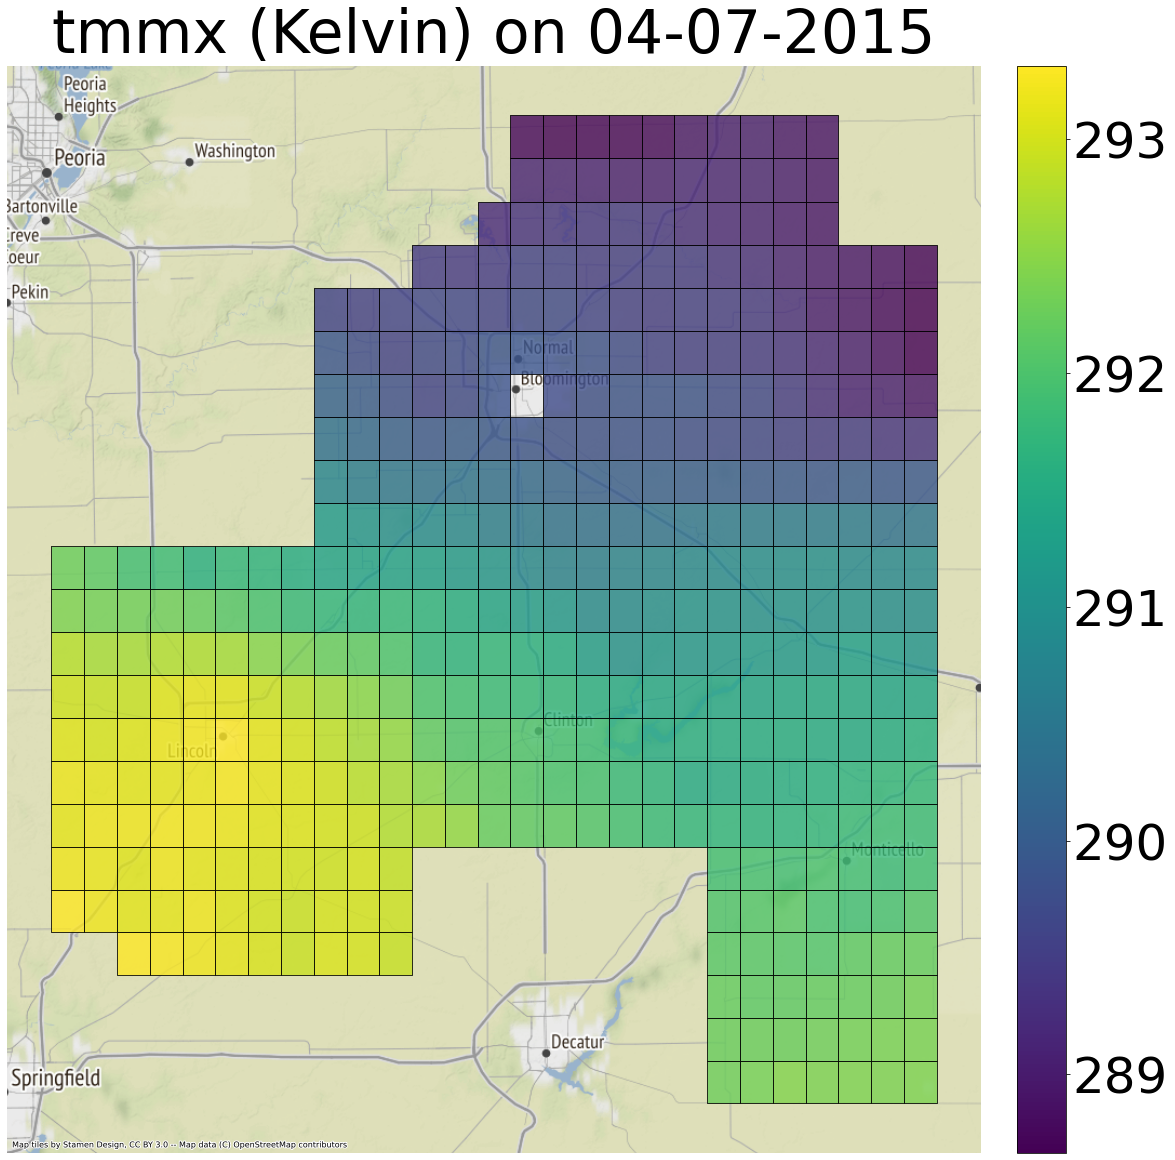

In [66]:
plot_i_disaggregation(
    m, 
    gdf_gridmet[(gdf_gridmet["key"].isin(plot_keys)) & (gdf_gridmet["year"]==2015)], 
    3,
    tmmx_cols, 
    scaler_y=scaler_y, 
    bag_shapefile=county_shapes[county_shapes["key"].isin(plot_keys)], 
)
plt.savefig("../../results/usa_crops/tmmx_disagg.pdf")

/home/hbz15/MVBAgg/.env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


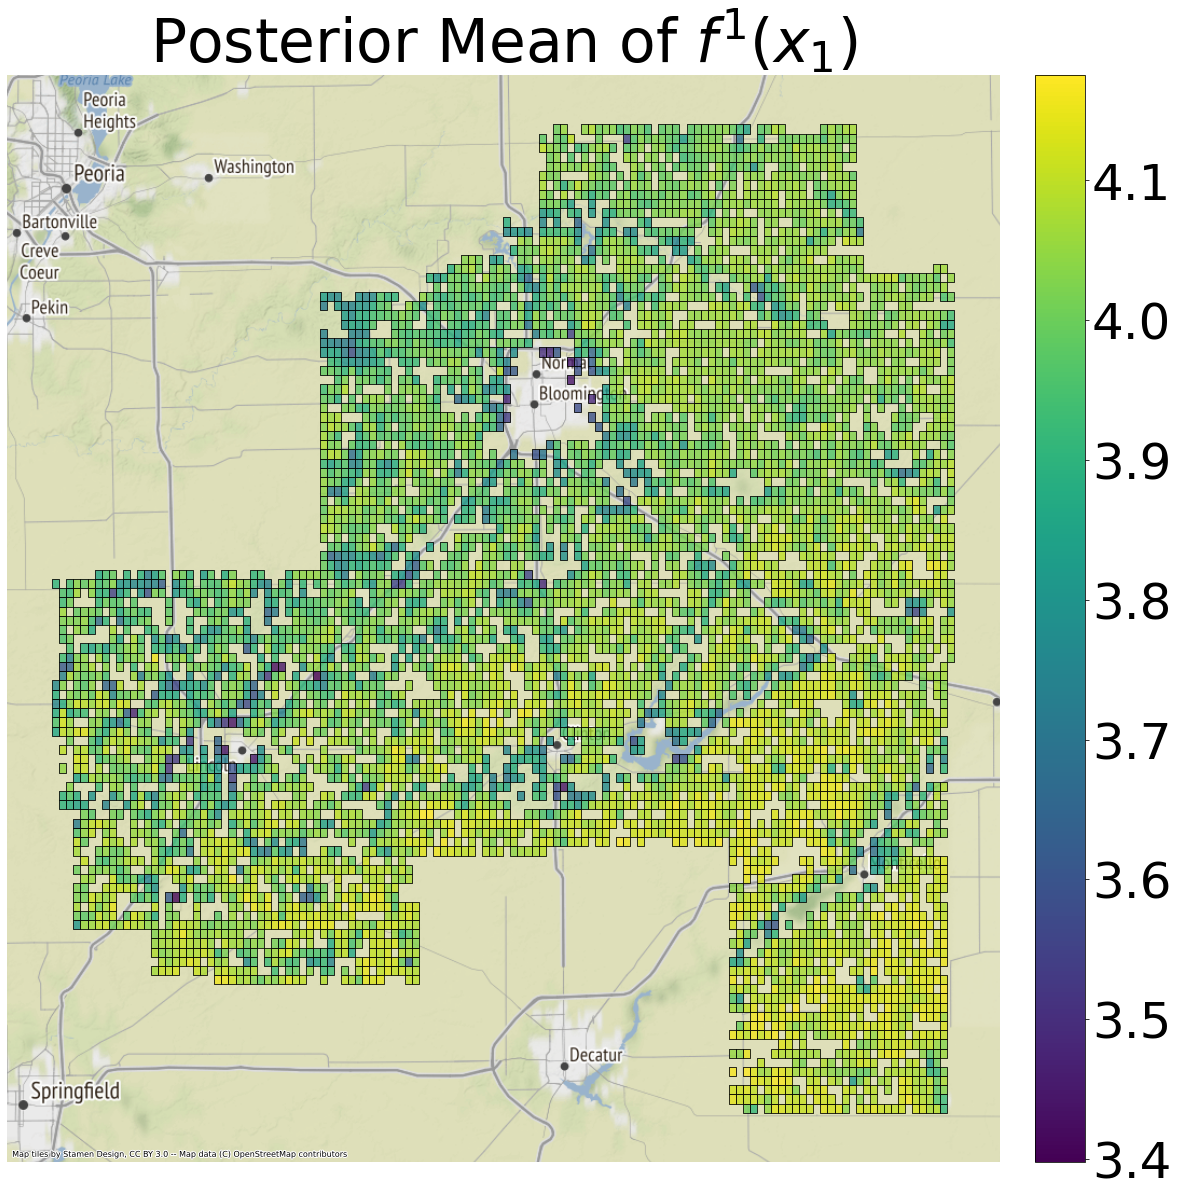

In [145]:
plot_i_disaggregation(
    m, 
    gdf_modis[(gdf_modis["key"].isin(plot_keys)) & (gdf_modis["year"]==2015)], 
    1,
    modis_cols, 
    scaler_y=scaler_y, 
    bag_shapefile=county_shapes[county_shapes["key"].isin(plot_keys)], 
)
plt.savefig("../../results/usa_crops/modis_disagg.pdf")

In [141]:
gdf_latlon["key"] = gdf_latlon["County"] + "-" + gdf_latlon["State"]
gdf_latlon["geometry"] = gdf_latlon[["longitude", "latitude"]].apply(lambda x: create_pixel_square(x, modis_resolution/2), axis=1)
gdf_latlon[col_latlon] = scaler_latlon.transform(gdf_latlon[col_latlon].values)

/home/hbz15/MVBAgg/.env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


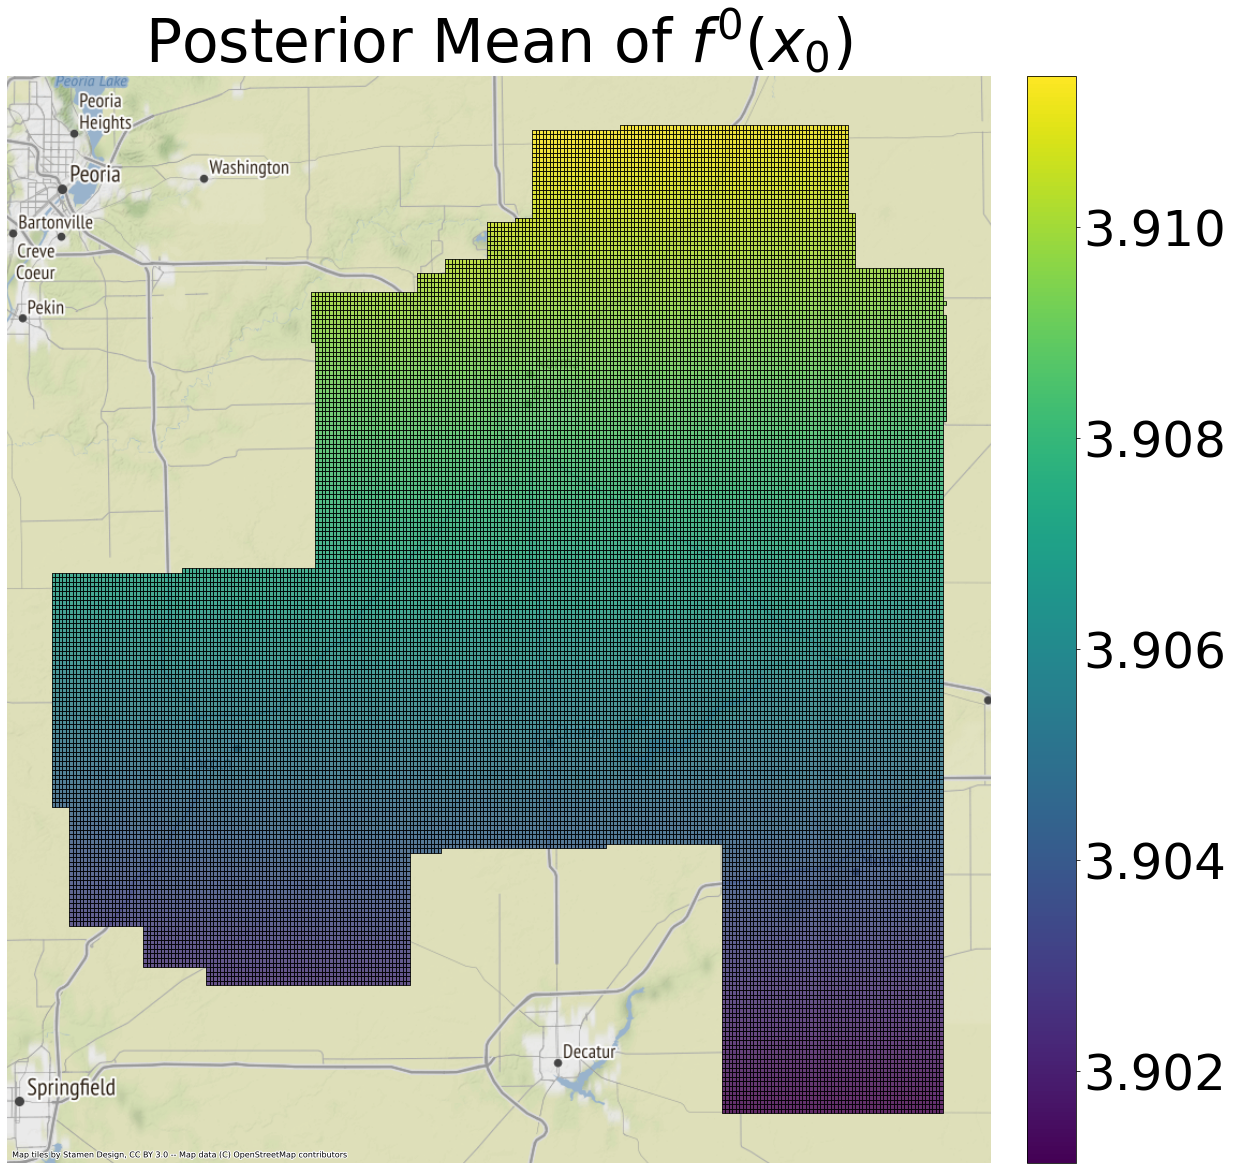

In [142]:
plot_i_disaggregation(
    m, 
    gdf_latlon[gdf_latlon["key"].isin(plot_keys)], 
    0,
    latlon_cols, 
    scaler_y=scaler_y, 
    bag_shapefile=county_shapes[county_shapes["key"].isin(plot_keys)], 
)
plt.savefig("../../results/usa_crops/latlon_disagg.pdf")

In [143]:
m

name,class,transform,prior,trainable,shape,dtype,value
MVBAgg.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.23577854375075882
MVBAgg.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2.5561072527727884
MVBAgg.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0503262971344682
MVBAgg.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,5.246254876948254
MVBAgg.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.10853782440505937
MVBAgg.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,7.910368167015443
MVBAgg.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.246875507274524
MVBAgg.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,(),float64,4.141795403082189
MVBAgg.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.09308136240659787
MVBAgg.inducing_variable.Z,Parameter,Identity,,False,"(307, 41)",float64,"[[-0.89662724, 0.00284634, 0.03377268..."


In [107]:
sobol, variance_full = m.compute_sobol(gdf_joined_all_final, [latlon_cols, modis_cols, pr_cols, tmmx_cols])

In [108]:
sum(sobol.values()) + m.likelihood.variance.numpy()/variance_full

0.9999999999999999

In [111]:
sum(sobol.values())

0.8147025979663751

In [109]:
variance_full, m.likelihood.variance/variance_full

(0.5023349565889056,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.18529740203362474>)

In [110]:
sobol # the negative terms are essentially 0 and negative due to Monte Carlo approximation

{'0': 0.08908664749819135,
 '1': 3.3570533450133487e-07,
 '2': 0.015689775064823185,
 '3': 0.3531479921356875,
 '0-1': -0.0002098371193374939,
 '0-2': 0.024423608328985755,
 '0-3': 0.28135484398819016,
 '1-2': -3.443436189577406e-05,
 '1-3': -0.0003932445581285617,
 '2-3': 0.05163691128452449}

## VBAgg

In [5]:
from src.svgp import VBagg
from src.bagData import create_bag_sameresolution_dictionary
# read in user-specified counties and states to study
counties_states = pd.read_csv("../../data/crops/counties-states.csv")
dates = ['04-07', '04-23', '05-09', '05-25',
       '06-10', '06-26', '07-12', '07-28',
       '08-13', '08-29', '09-14', '09-30',
       '10-16']

# read in and take subset of yield data
df_yield = pd.read_csv("../../data/crops/soybean_yield_2015_2017.csv")
df_yield["key"] = df_yield["County"] + "-" + df_yield["State"]
df_yield = df_yield[df_yield["key"].isin(counties_states["key"])]
df_yield.rename(columns={"Year": "year"}, inplace=True)
df_yield.rename(columns={"Year": "year"}, inplace=True)
df_yield = df_yield.drop_duplicates(["County", "State", "year"])
df_yield["Value"] = np.log(df_yield["Value"])

# read in and take subset of features data
df_features = pd.read_csv("../../data/crops/processed_covariates/MOD13Q1-GRIDMET-downsampled_data.csv")
df_features["key"] = df_features["County"] + "-" + df_features["State"]
df_features = df_features[df_features["key"].isin(counties_states["key"])]

# dates of the features
features = ["key", "County", "State", "year", "longitude", "latitude"] + [f"EVI_{date}" for date in dates] + [f"pr_{date}" for date in dates] + [f"tmmx_{date}" for date in dates]
df_features = df_features[features]
df_features = df_features.drop_duplicates(["County", "State", "year", "longitude", "latitude"])

assert df_yield.shape[0] == 768

# %%
# write down index of the features
col_index_space = [0, 1]
col_index_modis = [2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12,13,14]
col_index_pr = [15,16,17,18,19,20,21,22,23,24,25,26,27]
col_index_tmmx = [28 + i for i in range(13)]
col_index_all = col_index_space + col_index_modis + col_index_pr + col_index_tmmx

# %% [markdown]
# ## Experimental Setup

kf = KFold(n_splits=5, random_state=seed, shuffle=True)
output_types=(
    tf.int64, 
    tf.float64, 
    tf.float64, 
    tf.float64
)
keys = list(set(df_yield[df_yield["year"]==2015].key).intersection(set(df_yield[df_yield["year"]==2017].key)))
keys.sort()

# %% [markdown]
# Now we create a dictionary in the required format of src.bagData.bagData

# %%
RMSE = []
MAPE  = []
LL  = []
training_time = []
iterations = 20000
num_minibatch = 50
lr_adam = 0.001#
max_pixels = 100
latlon_cols = ["longitude", "latitude"]
modis_cols = [f"EVI_{date}" for date in dates]
pr_cols = [f"pr_{date}" for date in dates] 
tmmx_cols = [f"tmmx_{date}" for date in dates] 
all_features = latlon_cols + modis_cols + pr_cols + tmmx_cols

for fold, (train_index, test_index) in tqdm(enumerate(kf.split(keys))):
    county_keys = [keys[key] for key in train_index]
    
    X_train = df_features.loc[(df_features["key"].isin(county_keys)) & (df_features["year"]==2015), all_features].values
    X_test = df_features.loc[(df_features["key"].isin(county_keys)) & (df_features["year"]==2017), all_features].values
    y_train = df_yield[(df_yield["key"].isin(county_keys)) & (df_yield["year"]==2015)].Value.values[:, None]
    y_test = df_yield[(df_yield["key"].isin(county_keys)) & (df_yield["year"]==2017)].Value.values[:, None]

    scaler_x = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    X_train, y_train = scaler_x.transform(X_train), scaler_y.transform(y_train)
    X_test = scaler_x.transform(X_test)

    train_dict = create_bag_sameresolution_dictionary(
        X_train, 
        y_train, 
        df_features[(df_features["key"].isin(county_keys)) & (df_features["year"]==2015)],
        df_yield[(df_yield["key"].isin(county_keys))& (df_yield["year"]==2015)],
        county_keys,
        max_pixels
    )
    test_dict = create_bag_sameresolution_dictionary(
        X_test, 
        y_test, 
        df_features[(df_features["key"].isin(county_keys)) & (df_features["year"]==2017)],
        df_yield[(df_yield["key"].isin(county_keys)) & (df_yield["year"]==2017)],
        county_keys,
        max_pixels
    )

    train_bags = BagData(bag_data=train_dict, bags_metadata="2015 yields")
    test_bags = BagData(bag_data=test_dict, bags_metadata="2017 yields")

    ds_train = create_tensorflow_iterator(train_bags.gen_bags, output_types=output_types)

    # create inducing points
    kmeans = KMeans(1)
    Z = np.zeros((train_bags.num_bags, len(col_index_all)))
    for i, bag in enumerate(train_bags.bags):
        data = train_bags[bag]
        Z_tmp = kmeans.fit(data[2]).cluster_centers_
        Z[i] = Z_tmp

    # fit and train GP regression model
    k_space = gpflow.kernels.Matern32(active_dims=col_index_space)
    k_modis = gpflow.kernels.RBF(active_dims=col_index_modis)
    k_pr = gpflow.kernels.RBF(active_dims=col_index_pr)
    k_tmmx = gpflow.kernels.RBF(active_dims=col_index_tmmx)
    k = k_space + k_modis + k_pr + k_tmmx
    m = VBagg(kernel=k, likelihood=gpflow.likelihoods.Gaussian(), inducing_variable=Z,num_data=train_bags.num_bags)
    gpflow.set_trainable(m.inducing_variable, False)
    
    load_model(m, f"../../results/usa_crops/VBagg_fold{fold}.pickle")
    break

100%|██████████| 307/307 [00:00<00:00, 667.74it/s]
2022-01-19 14:40:25.642713: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-19 14:40:25.642748: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-01-19 14:40:25.642769: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-01-19 14:40:25.642895: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-01-19 14:40:25.642912: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-01-19 14:40:25.642916: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-01-19 14:40:25.644059: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (

In [82]:
sobol, variance_full = m.compute_sobol(df_features, [latlon_cols, modis_cols, pr_cols, tmmx_cols])

In [83]:
sobol

{'0': 4.385494186954861e-133,
 '1': 0.0,
 '2': 0.05836434526408744,
 '3': 0.0,
 '0-1': 0.0,
 '0-2': 4.4800319056698266e-69,
 '0-3': 0.0,
 '1-2': 0.0,
 '1-3': 0.0,
 '2-3': 0.0}

In [87]:
variance_full, m.likelihood.variance/variance_full

(0.10562933257839714,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9511368766126314>)

In [7]:
# calculate sobol for each county
sobol_counties = {}
for key in tqdm(keys):
    sobol, variance_full = m.compute_sobol(df_features[df_features["key"]==key], [latlon_cols, modis_cols, pr_cols, tmmx_cols])
    sobol["variance_full"] = variance_full
    sobol_counties[key] = sobol

100%|██████████| 384/384 [00:27<00:00, 13.91it/s]
